## Intro

This example project concerns itself with
- predicting the value of a car based on information like mileage, the make and model of the car.
- quantifying depreciation of a car w.r.t the mileage it clocks up


## Mount Google Drive to access car listing data

In [1]:
#@title
## Mounting google drive as a virtual `drive` to gain access to data 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

path = '/gdrive/My Drive/Python/Tutorials/webscrapping'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


## Import analysis libraries and set plot aesthetics

In [0]:
!pip install --upgrade yellowbrick

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError, CooksDistance
from statsmodels.api import qqplot
from pprint import pprint

In [0]:
## Controlling plot aesthetics
# plt.style.use('fivethirtyeight')
# plt.rcParams['grid.linestyle'] = '-.'
# plt.rcParams['axes.grid'] = True
# plt.rcParams['font.size'] = 12
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['patch.facecolor'] = 'white';

sns.set(style="whitegrid", palette="muted", color_codes=True)

## Import data and check columns and rows

In [0]:
dtype_dict = {'Year':int, 'Make':str, 'Model':str, 'Detailed_model':str, 'Price':float, 'Mileage':float, 'Website': str}
car_listings = pd.read_csv(path + '/car_listings.csv',dtype=dtype_dict)

In [6]:
car_listings.head()

,Year,Make,Model,Detailed_model,Price,Mileage,Website
0,2018,Toyota,Camry,XLE,17995.0,26882.0,CG
1,2005,Toyota,Camry,XLE,4495.0,107990.0,CG
2,2012,Toyota,Camry,SE,8995.0,81010.0,CG
3,2013,Toyota,Camry,SE,5995.0,157800.0,CG
4,2018,Toyota,Camry,LE,16999.0,15324.0,CG


In [7]:
display(car_listings.describe())
print("====")
display(car_listings.info())

,Year,Price,Mileage
count,11018.000000,10943.000000,11018.000000
mean,2015.608550,14559.980627,48525.551370
std,2.883831,4972.862918,36511.691813
min,1998.000000,1700.000000,5.000000
25%,2014.000000,11944.000000,24338.000000
50%,2016.000000,14999.000000,39331.500000
75%,2018.000000,17600.000000,60291.750000
max,2019.000000,33500.000000,381748.000000


====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11018 entries, 0 to 11017
Data columns (total 7 columns):
Year              11018 non-null int64
Make              11018 non-null object
Model             11018 non-null object
Detailed_model    10856 non-null object
Price             10943 non-null float64
Mileage           11018 non-null float64
Website           11018 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 602.6+ KB


None

Some rows in the car_listing dataframe miss 'Price' info. We therefore need to remove them because listing price is crucial for the following analysis.

In [0]:
car_listings = car_listings[car_listings.Price.notnull()]

In [9]:
car_listings.groupby(by='Make').agg({'Price':['mean', 'count'], 'Mileage':'mean'})

Price             Mileage
                    mean count          mean
Make                                        
Chevrolet   13975.739568   695  42248.130935
Ford        14048.936154  1347  49715.406088
Honda       17985.075795  2045  37069.151589
Hyundai     13355.761605  1271  44674.967742
Nissan      12894.916343  2319  57713.732643
Toyota      14678.426728  2402  51933.990841
Volkswagen  13631.096065   864  49531.853009

## Removing duplicate values

Car listing websites may allow the same car to be posted several times.
This may negatively affect our analysis so we need to remove duplicate 
entries in the car listing data frame

In [0]:
car_listings = car_listings.drop(car_listings[car_listings[['Year',	'Make',	'Model',	'Price',	'Mileage']].duplicated()].index)

In [11]:
# After removing duplications
car_listings.groupby(by='Make').agg({'Price':['mean', 'count'], 'Mileage':'mean'})

Price             Mileage
                    mean count          mean
Make                                        
Chevrolet   15412.324324   370  36917.727027
Ford        15839.169385   797  41607.580928
Honda       17660.135161  1058  42601.015123
Hyundai     14446.772544   743  41476.531629
Nissan      15126.008442  1540  43187.042208
Toyota      16438.825361  1317  44794.329537
Volkswagen  14481.959720   571  45425.737303

## Correlation matrix for Mileage, Year and Price

In [12]:
car_listings.corr()

,Year,Price,Mileage
Year,1.000000,0.720747,-0.705035
Price,0.720747,1.000000,-0.752231
Mileage,-0.705035,-0.752231,1.000000


## Box plot to visualize distribution of data accross models

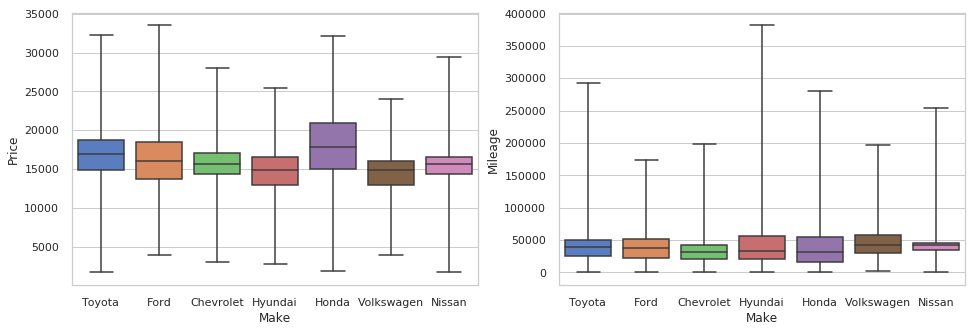

In [13]:
fig = plt.figure(figsize=(16,5))
ax1, ax2 = fig.subplots(1, 2)
sns.boxplot(x="Make", y="Price", data=car_listings, whis="range", ax=ax1)
sns.boxplot(x="Make", y="Mileage", data=car_listings, whis="range", ax=ax2)


In [0]:

def plot(make, df=None, plt_type='scatter'):
  if df is None:
    print("data frame none")
    df = car_listings
  fig = plt.figure(figsize=(12,5))
  axes = fig.subplots(1,2)

  # labels = {
  #     'Mileage':['0', '25K','50K', '100K', '125K', '150K', '200K'], 
  #     'Year':range(1995, 2021, 5),
  #     }
  
  for index, column in enumerate(['Mileage', 'Year']):
    # axes[index].set_xticklabels(labels[column])
    if plt_type == 'scatter':
      sns.scatterplot(df[(df.Make == make)][column],df[df.Make == make]['Price'], ax=axes[index])
    elif plt_type == 'kde':
      sns.kdeplot(df[column], ax=axes[index],shade=True)
    axes[index].set_title(make)

In [0]:
def transform(series, transformation):
  '''Transform a series into another series
  '''
  if callable(transformation):
    return transformation(series)
  elif transformation == 'center':
    return series - np.mean(series)
  elif transformation == 'standardize':
    return (series - np.mean(series))/np.std(series)

def train_linear_regression(train, regularizer=None):
  ''' Takes in the training set 'train' and performs LASSO(ElasticNet)
  in two steps. First LASSO(ElasticNet) Cross Validation is used to 
  select the alpha regularization hyper-parameter that optimizes 
  between OLS and regularization costs. Second, this parameter is 
  used to train a model'''

  if regularizer is None:
    model = LinearRegression().fit(train.drop('Price', axis=1), train.Price)

  elif regularizer == 'e':
    elasticnet_cv = ElasticNetCV(cv=5, random_state=0, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
    elasticnet_cv.fit(train.drop('Price', axis=1), train.Price)

    model = ElasticNet(alpha=elasticnet_cv.alpha_, l1_ratio=elasticnet_cv.l1_ratio_, random_state=0)
    model.fit(train.drop('Price', axis=1), train.Price)
  elif regularizer == 'r':
    ridge_cv = RidgeCV(cv=10)
    ridge_cv.fit(train.drop('Price', axis=1), train.Price)

    model = Ridge(random_state=0,alpha=ridge_cv.alpha_)
    model.fit(train.drop('Price', axis=1), train.Price)
  else:
    lasso_cv = LassoCV( cv=10, random_state=0)
    lasso_cv.fit(train.drop('Price', axis=1), train.Price)

    model = Lasso(random_state=0,alpha=lasso_cv.alpha_)
    model.fit(train.drop('Price', axis=1), train.Price)
  return model

def train_test_plot(dataframe, columns, visualize=True, return_test_set=False, regularizer=None):
  train, test = train_test_split(dataframe[columns],shuffle=True)
  model = train_linear_regression(train, regularizer)

  # Price should be the last in the 'columns' list!
  predicted = dataframe[columns[:-1]].dot(model.coef_) + model.intercept_
  r2_score = model.score(test[columns[:-1]], test['Price'])

  if visualize:
    residual_visualizer = ResidualsPlot(model)

    residual_visualizer.fit(train[columns[:-1]], train['Price'])  
    residual_visualizer.score(test[columns[:-1]], test['Price'])  
    residual_visualizer.poof() 
  if return_test_set:
    return model, test
  return model

### 1. Analyzing the Toyota Camry data

In [16]:
toyota = car_listings[(car_listings.Make == 'Toyota')].copy()
toyota.sort_values(by='Mileage')
toyota.reset_index(inplace=True,drop=True)
toyota.describe()

,Year,Price,Mileage
count,1317.00000,1317.000000,1317.000000
mean,2016.16325,16438.825361,44794.329537
std,2.80169,4143.051229,32001.078024
min,1998.00000,1700.000000,115.000000
25%,2016.00000,14900.000000,25373.000000
50%,2017.00000,16990.000000,39077.000000
75%,2018.00000,18699.000000,49637.000000
max,2019.00000,32200.000000,293258.000000


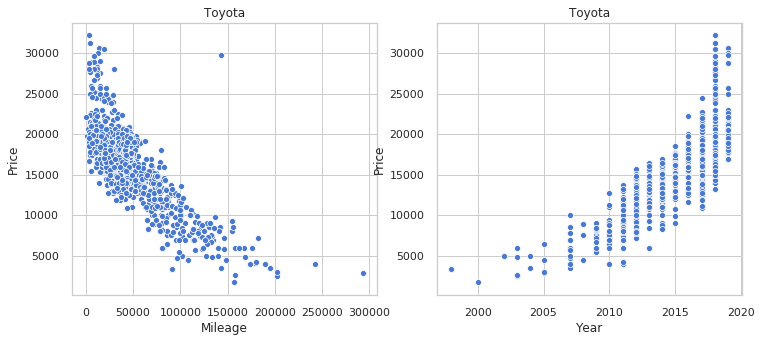

In [17]:
plot('Toyota', toyota)

In [18]:
toyota[(toyota.Mileage > 100000) & (toyota.Price > 20000)]

,Year,Make,Model,Detailed_model,Price,Mileage,Website
839,2019,Toyota,Camry,XSE,29799.0,142894.0,ED


In [0]:
toyota.drop(toyota[(toyota.Mileage > 100000) & (toyota.Price > 20000)].index, inplace=True)

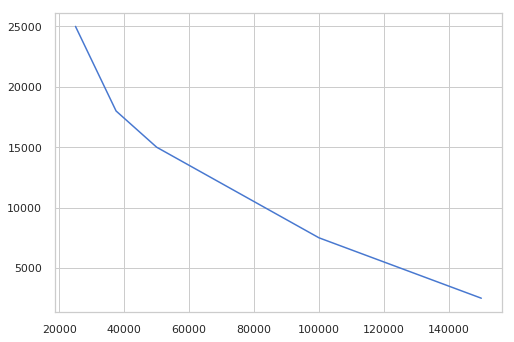

In [20]:
X = [25e3, 37.5e3, 50e3, 100e3, 125e3, 150e3]
Y = [25e3, 18e3, 15e3, 7.5e3, 5e3, 2.5e3]
sns.lineplot(X,Y)

In [21]:
toyota.corr()

,Year,Price,Mileage
Year,1.000000,0.805127,-0.754907
Price,0.805127,1.000000,-0.795519
Mileage,-0.754907,-0.795519,1.000000


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_test = toyota[['Mileage', 'Year']].copy()
vif_test['Intercept'] = np.ones(vif_test.shape[0])

pd.Series([variance_inflation_factor(vif_test.values, i) for i in range(vif_test.shape[1])], index=vif_test.columns)

Mileage      2.324958e+00
Year         2.324958e+00
Intercept    1.208486e+06
dtype: float64

### 1.1 Check botton and top ends of the Price and Mileage columns

In [23]:
# Price
display(toyota.sort_values(by='Price').head())
display(toyota.sort_values(by='Price').tail())

,Year,Make,Model,Detailed_model,Price,Mileage,Website
1051,2000,Toyota,Camry,CE,1700.0,157015.0,ED
811,2003,Toyota,Camry,XLE,2500.0,202790.0,ED
923,2003,Toyota,Camry,XLE,2634.0,157500.0,ED
353,2005,Toyota,Camry,LE I4,2845.0,293258.0,TC
1274,2005,Toyota,Camry,LE,2995.0,202840.0,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
350,2019,Toyota,Camry,XSE V6,29980.0,13096.0,TC
352,2018,Toyota,Camry,XSE V6,30520.0,19116.0,TC
107,2019,Toyota,Camry,XSE V6,30670.0,13655.0,TC
721,2018,Toyota,Camry,XLE,31300.0,3934.0,ED
736,2018,Toyota,Camry,XSE,32200.0,2893.0,ED


In [24]:
# Mileage
display(toyota.sort_values(by='Mileage').head())
display(toyota.sort_values(by='Mileage').tail())
display([toyota.Mileage.mean() - (3*toyota.Mileage.std()), toyota.Mileage.mean() + (3*toyota.Mileage.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
735,2019,Toyota,Camry,SE,22100.0,115.0,ED
787,2019,Toyota,Camry,L,19797.0,1193.0,ED
738,2019,Toyota,Camry,SE,20691.0,2300.0,ED
1191,2019,Toyota,Camry,LE,19489.0,2870.0,ED
736,2018,Toyota,Camry,XSE,32200.0,2893.0,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
632,2007,Toyota,Camry,SE,3494.0,194576.0,ED
811,2003,Toyota,Camry,XLE,2500.0,202790.0,ED
1274,2005,Toyota,Camry,LE,2995.0,202840.0,ED
1300,2010,Toyota,Camry,LE,3995.0,242756.0,ED
353,2005,Toyota,Camry,LE I4,2845.0,293258.0,TC


[-50976.16598497629, 140415.73741354773]

We have a handful of cars that are driven more than 3 times the standard deviation of mileage. These could be problematic when trying to fit a regression model as linear regression can be affected by outliers (esp. large ones)

In [25]:
outliers = toyota[toyota.Mileage > toyota.Mileage.mean() + (3*toyota.Mileage.std())]
# These 'outliers' are not that many so we can safely drop them
print(outliers.shape)

(26, 7)


In [0]:
toyota.drop(outliers.index, inplace=True)

In [27]:
toyota.describe()

,Year,Price,Mileage
count,1290.000000,1290.000000,1290.000000
mean,2016.316279,16654.757364,42117.417054
std,2.558388,3835.127689,25936.700559
min,1998.000000,3387.000000,115.000000
25%,2016.000000,14995.000000,25003.250000
50%,2017.000000,16995.000000,38648.500000
75%,2018.000000,18737.000000,48016.750000
max,2019.000000,32200.000000,140000.000000


In [28]:
# Year
display(toyota.sort_values(by='Year').head())
display(toyota.sort_values(by='Year').tail())
display([toyota.Year.mean() - (3*toyota.Year.std()), toyota.Year.mean() + (3*toyota.Year.std())])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
321,1998,Toyota,Camry,LE I4,3387.0,90940.0,TC
320,2002,Toyota,Camry,LE I4,4995.0,101315.0,TC
377,2003,Toyota,Camry,XLE I4,4800.0,133325.0,TC
17,2003,Toyota,Camry,LE I4,5995.0,81881.0,TC
284,2004,Toyota,Camry,LE I4,4923.0,127211.0,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
545,2019,Toyota,Camry,LE,19000.0,3111.0,ED
783,2019,Toyota,Camry,LE,18299.0,14640.0,ED
1166,2019,Toyota,Camry,L,19099.0,11716.0,ED
702,2019,Toyota,Camry,L,18995.0,31647.0,ED
516,2019,Toyota,Camry,LE,18572.0,17737.0,TC


[2008.6411136714687, 2023.9914444680662]

In [29]:
outliers_year = toyota[toyota.Year < toyota.Year.mean() - (3*toyota.Year.std())]

print(outliers_year.shape)

(20, 7)


In [0]:
toyota.drop(outliers_year.index, inplace=True)

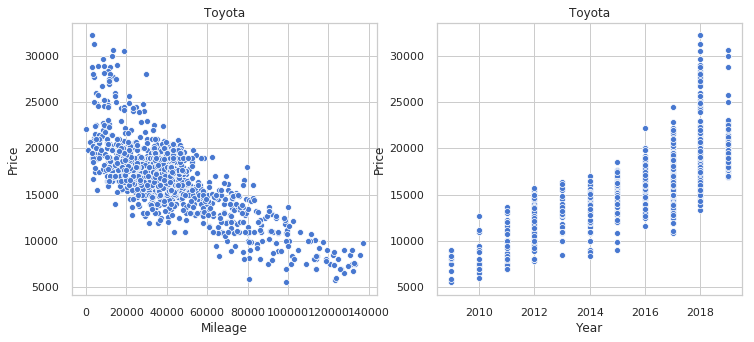

In [31]:
plot('Toyota', toyota)

2400.38890055506

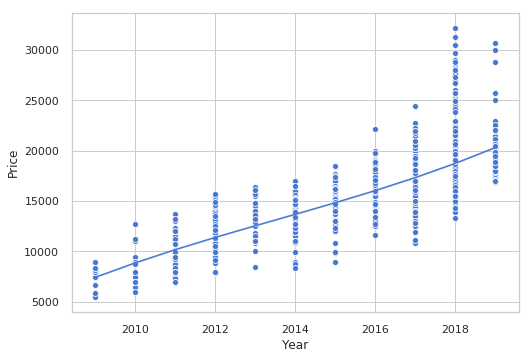

In [32]:
fig= plt.figure()
ax = fig.add_subplot()
polyfit3 = np.polyfit(toyota.Year, toyota.Price, 3)
fitted3 = np.poly1d(polyfit3)
sns.lineplot(toyota.Year, fitted3(toyota.Year), ax=ax)
sns.scatterplot('Year', 'Price', data=toyota, ax=ax)
np.sqrt(np.sum((fitted3(toyota.Year) - toyota.Price)**2)/toyota.shape[0])

       2
18.92 x - 7.501e+04 x + 7.432e+07
2402.25811711303


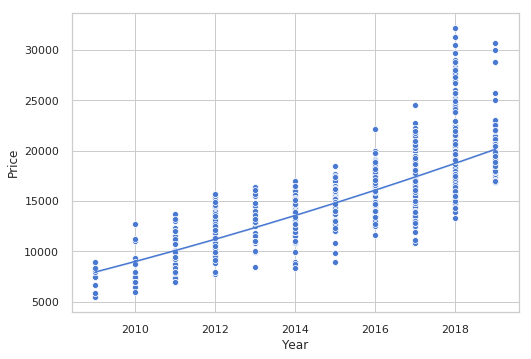

In [33]:
fig= plt.figure()
ax = fig.add_subplot()
polyfit2 = np.polyfit(toyota.Year, toyota.Price, 2)
fitted2 = np.poly1d(polyfit2)
sns.lineplot(toyota.Year, fitted2(toyota.Year), ax=ax)
sns.scatterplot('Year', 'Price', data=toyota, ax=ax)
print(fitted2)
print(np.sqrt(np.sum((fitted2(toyota.Year) - toyota.Price)**2)/toyota.shape[0]))

In [34]:
toyota.groupby(by='Website').agg({'Price':['count', 'min', 'mean', 'max'], 'Mileage':['min', 'mean', 'max']})

Price                                Mileage                        
        count     min          mean      max     min          mean       max
Website                                                                     
CG         12  7490.0  14404.916667  19300.0  9044.0  41828.500000  101500.0
ED        770  5499.0  16875.253247  32200.0   115.0  41694.572727  135610.0
TC        488  5780.0  16784.446721  30670.0  3418.0  40195.889344  137000.0

In [35]:
toyota.groupby(by='Detailed_model').agg({'Mileage':['count', 'mean'], 'Price':[ 'mean']})

Mileage                        Price
                              count           mean          mean
Detailed_model                                                  
2014 Hybrid                       2   64846.500000  13241.000000
2014 L I4                         1   63009.000000  10980.000000
2014 LE I4                       10   72422.400000  12095.200000
2014 SE I4                        4   67080.750000  12883.500000
2014 SE Sport I4                  1   72341.000000  14500.000000
2014 SE V6                        1   70225.000000  16130.000000
2014 XLE I4                       2   52783.000000  16199.000000
2014 XLE V6                       1   31523.000000  16500.000000
Base                              1  113667.000000   6946.000000
Hybrid                           22   46411.318182  18261.818182
I4                                2  106666.000000   8721.500000
L                                42   31905.142857  17637.000000
L I4                             11   34250.818182  17218.090909
LE                              362   39921.212707  16472.049724
LE FWD                            1    9044.000000  19300.000000
LE I4                           164   39268.067073  15745.451220
LE V6                             4  101604.000000   8745.750000
SE                              308   43556.477273  16937.506494
SE I4                           132   40545.825758  16431.712121
SE Limited Edition                1   47460.000000  14600.000000
SE Special Edition I4             1   40407.000000  17500.000000
SE Sport Limited Edition I4       1   92561.000000  10990.000000
SE Used                           1   25467.000000  14699.000000
SE V6                             6   72821.666667  12547.500000
Special Edition                   2   32703.500000  14799.500000
XLE                              62   44721.790323  16677.612903
XLE I4                           41   35039.146341  18122.878049
XLE V6                           15   59629.200000  15694.400000
XSE                              38   27263.605263  21654.210526
XSE I4                           20   30296.950000  20773.600000
XSE V6                           11   14936.545455  28473.454545

In [36]:
polyfit2 = np.polyfit(toyota.Year, toyota.Price, 2)
quadratice_fit = np.poly1d(polyfit2)
print(quadratice_fit)

       2
18.92 x - 7.501e+04 x + 7.432e+07


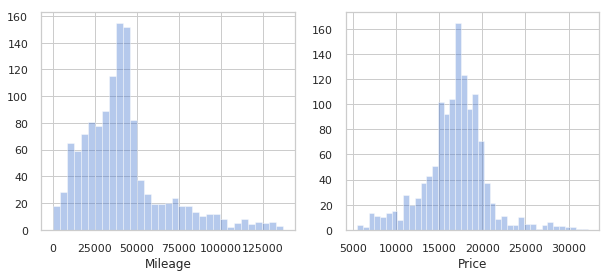

In [37]:
fig = plt.figure(figsize=(10, 4))
axes = fig.subplots(1,2)
sns.distplot(toyota.Mileage, kde=False, ax=axes[0])
sns.distplot(toyota.Price, kde=False, ax=axes[1])

In [38]:
np.quantile(toyota.Mileage, q=np.arange(0.1,1,0.1))

array([13260. , 21671.4, 28125.4, 34057. , 38422. , 41649.8, 44686.6,
       52277. , 75364.9])

In [0]:
percentile97 = np.quantile(toyota.Price, q=0.97)

In [0]:
toyota.drop(toyota[toyota.Price > percentile97].index, inplace=True)

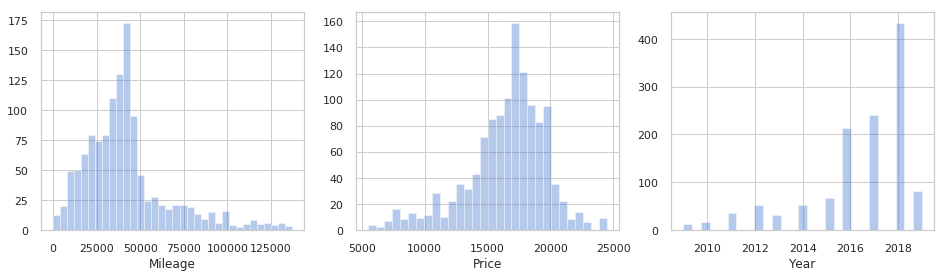

In [41]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(toyota.Mileage, kde=False, ax=axes[0])
sns.distplot(toyota.Price, kde=False, ax=axes[1])
sns.distplot(toyota.Year, kde=False, ax=axes[2])

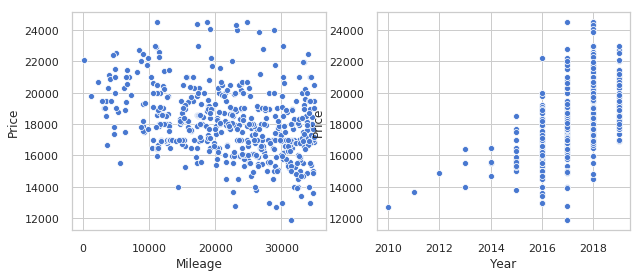

In [42]:
fig = plt.figure(figsize=(10, 4))
axes = fig.subplots(1,2)
sns.scatterplot(toyota[toyota.Mileage < 35000].Mileage, toyota.Price, ax=axes[0])
sns.scatterplot(toyota[toyota.Mileage < 35000].Year, toyota.Price, ax=axes[1])

### 1.3 Exploring features
---

In [0]:
toyota['Year_ctr'] = transform(toyota.Year, 'center')
toyota['Mileage_ctr'] = transform(toyota.Mileage, 'center')
toyota['Year_std'] = transform(toyota.Year, 'standardize')
toyota['Year_SQ_std'] = transform((toyota.Year**2), 'standardize')
toyota['Year_SQ_ctr'] = transform((toyota.Year**2), 'center')
toyota['Year_Quad2_std'] = transform(18.92 * toyota.Year**2, 'standardize')
toyota['Year_Quad1_std'] = transform(7.5e4 * toyota.Year, 'standardize')
toyota['Mileage_std'] = transform(toyota.Mileage, 'standardize')
toyota['Mileage_SQRT_std'] = transform(transform(toyota.Mileage, np.sqrt) , 'standardize')
toyota['Mileage_log'] = np.log2(toyota.Mileage)
toyota['Mileage_log_std'] = transform(transform(toyota.Mileage, np.log2), 'standardize')

toyota['XLE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XLE', na=False)] 
toyota['XSE'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('XSE', na=False)] 
toyota['Hybrid'] = [1 if entry else 0 for entry in toyota.Detailed_model.str.contains('Hybrid', na=False)] 

---

### 1.4 First attempt: Price as a simple linear function of Mileage

$$P_i = w_0 + w_1 M_i$$

where $P_i$ and $M_i$ are the $i^{th}$ price and standardized mileage <br/>
and $w_0$ and $w_1$ are the intercept and weight to be 'learned' by the model

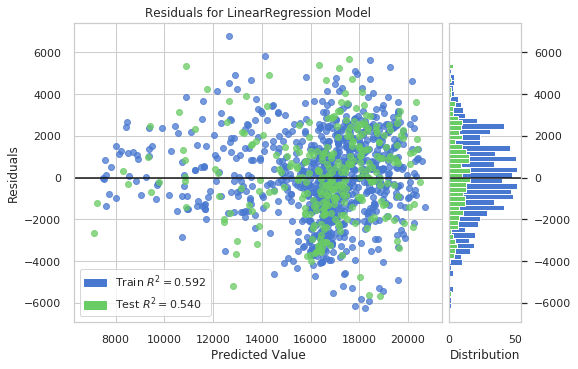

 
[-2435.22807024] 16528.86864765895


In [44]:
simple_linear_model = train_test_plot(toyota, ['Mileage_std', 'Price'])
print(" ")
print(simple_linear_model.coef_, simple_linear_model.intercept_)

The coefficient tells us that for every standardad deviation increase <br/>
in mileage (i.e. for every 31K mileage) the price of the car drops by 3600 dollars. 

However the residuals show strong ***heteroscedasticity*** that needs fixing. <br/>
Note that for a simple regression, our model has a high $R^2$ score but before <br/> considering model performance seriously, let us first try to fix the heteroscedasticity

Our model systematically under-predicted the price of the expensive cars.<br/>
As shown in the cell below, these cars also happen to have the least <br/>
mileage.

A linear relationship between mileage and price performs relatively well<br/>
for cars that are driven long enough. However, for those cars that reside <br/>
on the boundaries of being "New" and "Used" (i.e. cars whose mileage is <br/>
within the first few thousands), the effect of other factors is stronger <br/>than mileage.

### 1.5 Trying to fix heteroscedasticity by setting lower bound on mileage and adding more features

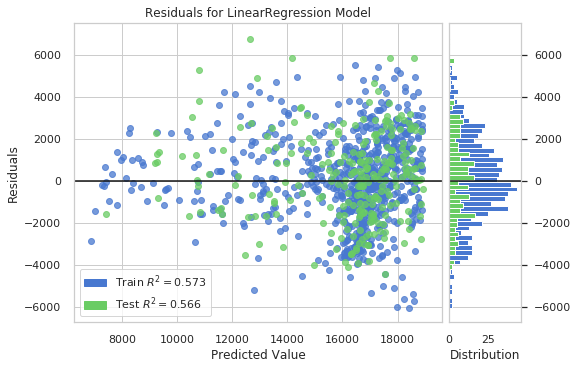

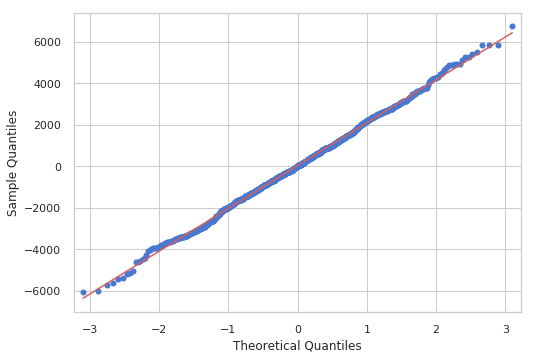

In [45]:
model = train_test_plot(toyota[(toyota.Mileage > 20000)], ['Mileage_std', 'Price'])
residuals = model.predict(toyota[(toyota.Mileage > 20000)][['Mileage_std']])  -  toyota[(toyota.Mileage > 20000)]['Price']
qqplot(residuals, line='r');

### Checking if the luxury versions are unevely distributed accross the years

If luxury versions are recent introduction they will also have less mileage.<br/>
This could impair the performance of our model if the luxury version are <br/>
distributed in a unbalanced manner accross the independent variable (i.e. mileage) <br/>

In [46]:
lux = toyota.Detailed_model.str.contains('XSE|XLE|Hybrid|V6', na=False)
display(toyota[lux].Year.describe())
print('\n')
display(toyota.drop(toyota[lux].index).Year.describe())

count     187.000000
mean     2015.390374
std         2.246267
min      2009.000000
25%      2014.500000
50%      2016.000000
75%      2017.000000
max      2018.000000
Name: Year, dtype: float64

count    1045.000000
mean     2016.620096
std         2.125420
min      2009.000000
25%      2016.000000
50%      2017.000000
75%      2018.000000
max      2019.000000
Name: Year, dtype: float64

No siginificant imbalance detected in the distribution of the luxury versions.

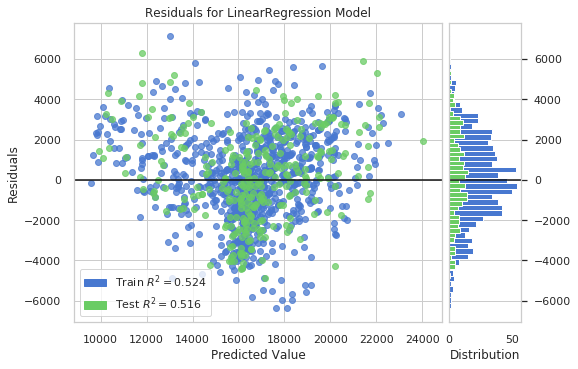

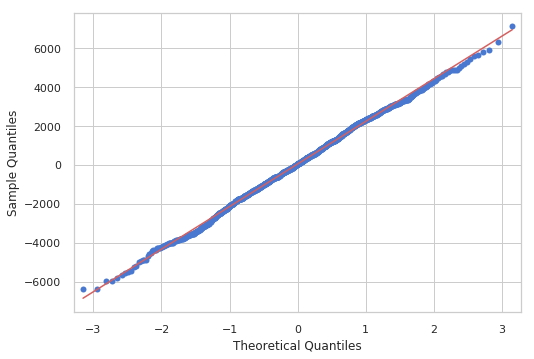

In [47]:
model = train_test_plot(toyota, ['Mileage_SQRT_std', 'Price'])
residuals = model.predict(toyota[['Mileage_SQRT_std']])  -  toyota['Price']
qqplot(residuals, line='r');

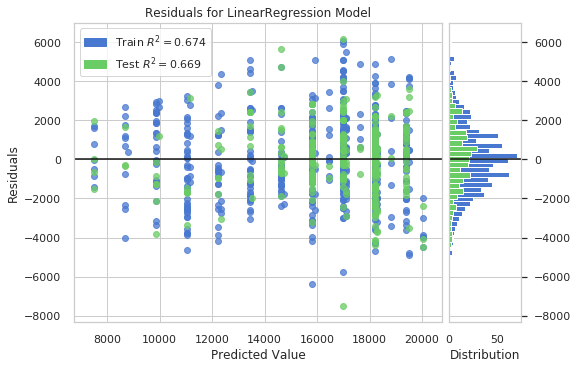

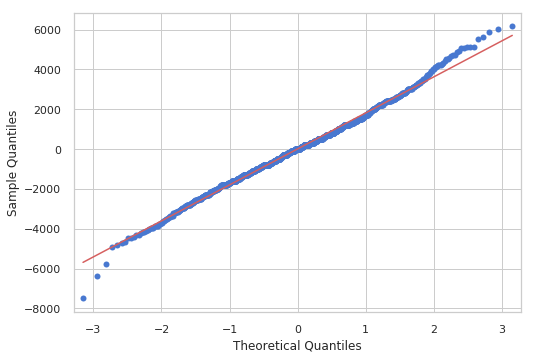

In [48]:
model = train_test_plot(toyota, ['Year_SQ_std','XSE','XLE', 'Price'])
residuals = model.predict(toyota[['Year_SQ_std','XSE','XLE']])  -  toyota['Price']
qqplot(residuals, line='r');

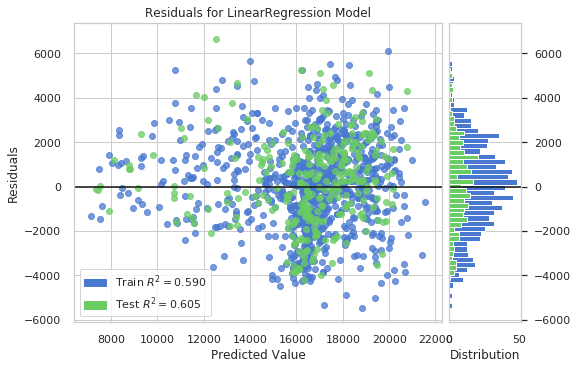

[-2421.12311609   576.26476454  1989.08749111  2156.12979512] 16380.245361806894


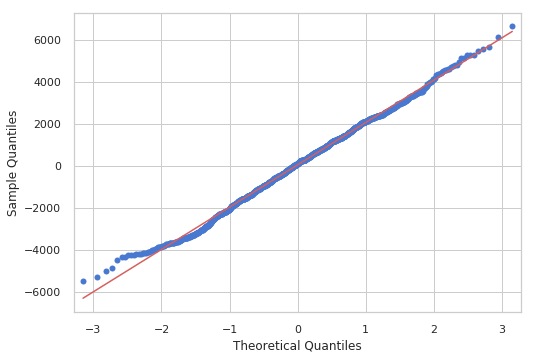

In [49]:
model = train_test_plot(toyota, ['Mileage_std', 'XLE', 'XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[['Mileage_std', 'XLE', 'XSE', 'Hybrid']])  -  toyota['Price']
qqplot(residuals, line='r')
print(model.coef_, model.intercept_)

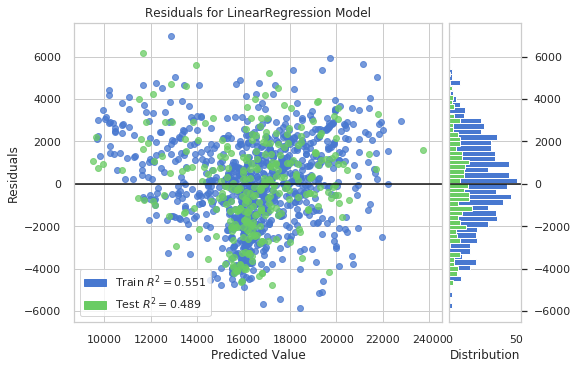

[-2290.09972893   334.85008076  2021.46756971  1504.43221084] 16334.326155429455


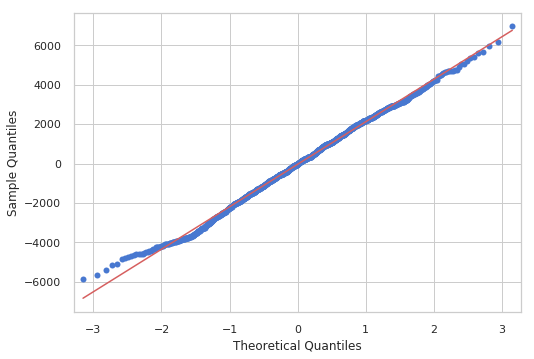

In [50]:
model = train_test_plot(toyota, ['Mileage_SQRT_std', 'XLE', 'XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[['Mileage_SQRT_std', 'XLE', 'XSE', 'Hybrid']])  -  toyota['Price']
qqplot(residuals, line='r')
print(model.coef_, model.intercept_)

In [51]:
toyota.Mileage.describe()

count      1232.000000
mean      42040.912338
std       24514.625216
min         115.000000
25%       26137.750000
50%       38987.500000
75%       47844.000000
max      137000.000000
Name: Mileage, dtype: float64

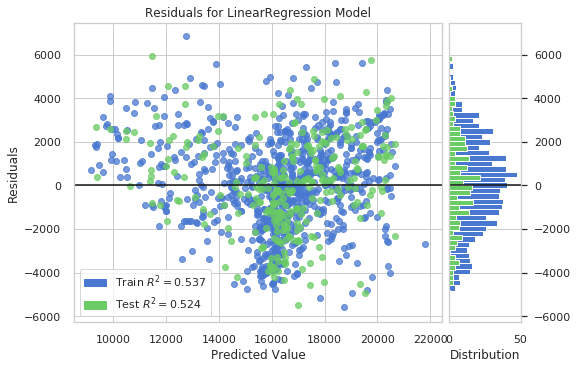

array([-2458.09305127,   363.68049729,  1441.11319374,  1399.82984286])

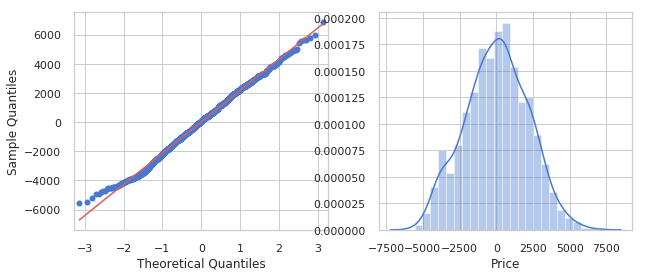

In [52]:
model = train_test_plot(toyota[toyota.Mileage > 10000], ['Mileage_SQRT_std', 'XLE', 'XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[toyota.Mileage > 10000][['Mileage_SQRT_std', 'XLE', 'XSE', 'Hybrid']])  -  toyota[toyota.Mileage > 10000]['Price']
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
model.coef_

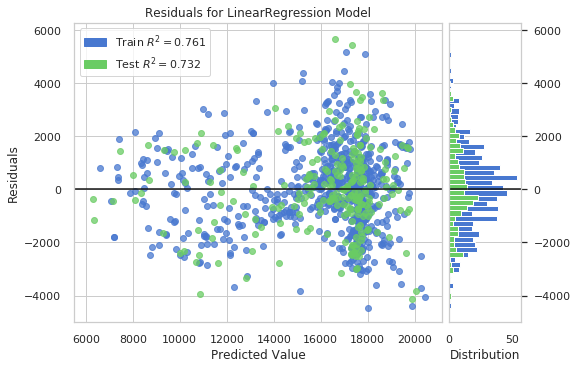

array([-1277.15612043,  1878.4008412 ,  1168.75973148,  1546.2522323 ,
        2674.30033105])

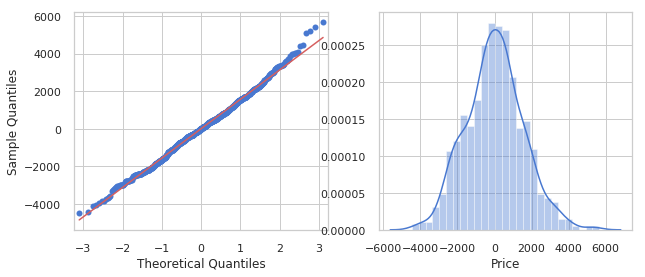

In [53]:
model = train_test_plot(toyota[toyota.Mileage > 20000], ['Mileage_SQRT_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[toyota.Mileage > 20000][['Mileage_SQRT_std', 'Year_std','XLE', 'XSE', 'Hybrid']])  -  toyota[toyota.Mileage > 20000]['Price']
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
model.coef_

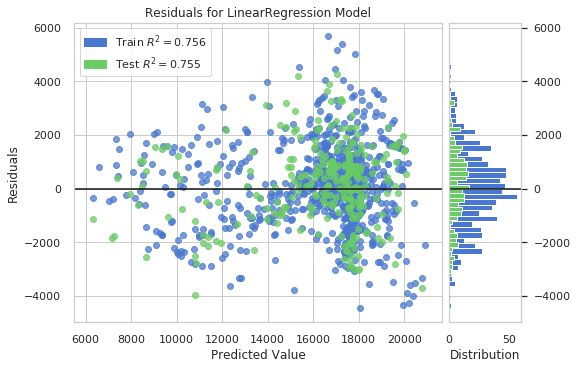

array([-1180.45505276,  1953.38073032,  1261.66663828,  1791.33540981,
        2539.84219695])

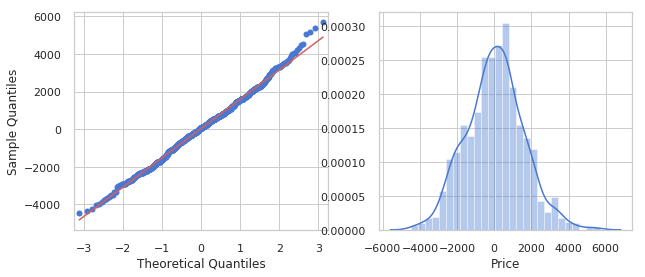

In [54]:
model = train_test_plot(toyota[toyota.Mileage > 15000], ['Mileage_SQRT_std', 'Year_SQ_std','XLE' ,'XSE', 'Hybrid','Price'])
residuals = model.predict(toyota[toyota.Mileage > 15000][['Mileage_SQRT_std', 'Year_SQ_std','XLE' ,'XSE', 'Hybrid']])  -  toyota[toyota.Mileage > 15000]['Price']
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
model.coef_

In [55]:
np.mean(residuals)/np.std(residuals, ddof=residuals.shape[0] -1)

0.0006934922538896742

In [56]:
print(np.std(residuals, ddof=1))
print(np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1)))

1549.6639822075665
1550.0809115305997


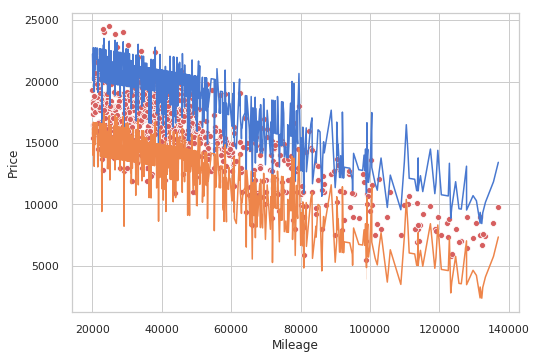

In [57]:
fig, ax = plt.subplots()
interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))
predictions = model.predict(toyota[toyota.Mileage > 20000][['Mileage_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid']])
upper, lower = predictions + interval, predictions - interval
sns.scatterplot(x=toyota[toyota.Mileage > 20000].Mileage, y=toyota[toyota.Mileage > 20000].Price, ax=ax,color='r')
sns.lineplot(x=toyota[toyota.Mileage > 20000].Mileage, y=upper, ax=ax)
sns.lineplot(x=toyota[toyota.Mileage > 20000].Mileage, y=lower, ax=ax)

In [58]:
pred = model.predict([[(40000 - np.mean(toyota.Mileage))/np.std(toyota.Mileage), (2016 - np.mean(toyota.Year))/np.std(toyota.Year), 0, 0, 0]])
print(pred)
print(pred - interval, pred + interval)
print(pred - interval/np.sqrt(toyota.shape[0]), pred + interval/np.sqrt(toyota.shape[0]))

[16091.92130392]
[13053.76271732] [19130.07989052]
[16005.36372794] [16178.47887989]


In [59]:
toyota[(toyota.Price > 25000) & (toyota.Mileage > 15000)][['Year', 'Mileage', 'Price', 'Detailed_model', 'Website']]

,Year,Mileage,Price,Detailed_model,Website


In [60]:
toyota.columns

Index(['Year', 'Make', 'Model', 'Detailed_model', 'Price', 'Mileage',
       'Website', 'Year_ctr', 'Mileage_ctr', 'Year_std', 'Year_SQ_std',
       'Year_SQ_ctr', 'Year_Quad2_std', 'Year_Quad1_std', 'Mileage_std',
       'Mileage_SQRT_std', 'Mileage_log_std', 'XLE', 'XSE', 'Hybrid'],
      dtype='object')

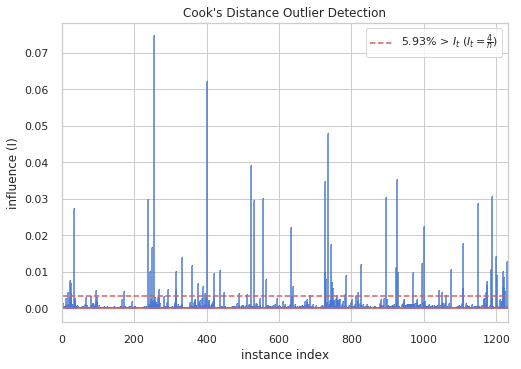

In [62]:
X, y = toyota[['Mileage_std', 'Year_std','XLE' ,'XSE', 'Hybrid']], toyota.Price

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.poof()

In [0]:
influential = toyota[(visualizer.distance_ > 0.02) & toyota.Mileage > 20000].index

In [0]:
mean = np.mean(np.array([model.coef_, model.coef_, model.coef_]), axis=0)
std = np.std(np.array([model.coef_, model.coef_, model.coef_]), axis=0,ddof=2)

list(zip(mean - 1.96* std , mean + 1.96*std))

In [0]:

def performance(data, columns, rep=10, regularizer=None):
  result = {
      'coef':[],
      'intercept':[],
      'score':[],
      'RMSE':[]
  }


  for _ in range(rep):
    model, test_set = train_test_plot(data, columns, visualize=False, return_test_set=True, regularizer=regularizer)
    residuals = model.predict(data[columns].drop('Price', axis=1))  -  data['Price']

    result['coef'].append(model.coef_)
    result['intercept'].append(model.intercept_)
    result['score'].append(model.score(test_set.drop('Price', axis=1), test_set.Price))
    result['RMSE'].append(np.sqrt(np.sum(residuals **2) / data.shape[0]))
  coef_means = np.mean(np.array(result['coef']), axis=0)
  coef_std = np.std(np.array(result['coef']), axis=0, ddof=len(result['coef']) - 1)

  intercept_mean = np.mean(result['intercept'])
  intercept_std = np.std(result['intercept'], ddof=len(result['intercept']) - 1)

  score_mean = np.mean(result['score'])
  score_std = np.std(result['score'], ddof=len(result['score']) - 1)

  RMSE_mean = np.mean(result['RMSE'])
  RMSE_std = np.std(result['RMSE'], ddof=len(result['RMSE']) - 1)

  stats = {
      'coef_means': coef_means,
      'coef_CI': list(zip(coef_means - 1.96 * coef_std/np.sqrt(len(result['coef'])), coef_means + 1.96 * coef_std/np.sqrt(len(result['coef'])))),
      'Intercept': {
          'mean': intercept_mean,
          'CI': [intercept_mean - 1.96 * intercept_std/np.sqrt(len(result['intercept'])), intercept_mean + 1.96 * intercept_std/np.sqrt(len(result['intercept']))]
      },
      'R2_on_testset': {
          'mean': score_mean,
          'CI': [score_mean - 1.96 * score_std/np.sqrt(len(result['score'])), score_mean + 1.96 * score_std/np.sqrt(len(result['score']))]
          },
      'RMSE': {
          'mean': RMSE_mean,
          'CI': [RMSE_mean - 1.96 *RMSE_std/np.sqrt(len(result['RMSE'])), RMSE_mean + 1.96 *RMSE_std/np.sqrt(len(result['RMSE']))]
      }
  }
  return stats

In [0]:
result = performance(toyota, ['Mileage_SQRT_std', 'XLE', 'XSE', 'Hybrid','Price'], rep=50, regularizer='e')
pprint(result)

In [0]:
result = performance(toyota, ['Mileage_SQRT_std', 'Year_std', 'Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota, ['Mileage_SQRT_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota[toyota.Mileage > 15000], ['Mileage_SQRT_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'], rep=50, regularizer='e')
pprint(result)

In [0]:
result = performance(toyota[toyota.Mileage > 15000], ['Mileage_SQRT_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid','Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota[toyota.Mileage > 15000], ['Mileage_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid','Price'], rep=50)
pprint(result)

In [0]:
result = performance(toyota[(toyota.Mileage > 40000)],['Mileage_log_std', 'Year_std','XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [0]:
result = performance(toyota[(toyota.Mileage > 15000)],['Mileage_SQRT_std', 'Year_SQ_std','XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [0]:
rows = toyota[(toyota.Mileage > 45000) ]
result = performance(rows,['Mileage_std', 'Year_std', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [0]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_ctr', 'Year_SQ_ctr', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

In [65]:
rows = toyota[(toyota.Mileage > 15000) ]
result = performance(rows,['Mileage_log', 'Year_ctr', 'XLE', 'XSE', 'Hybrid','Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [35094.47416402165, 38206.87019605341],
               'mean': 36650.67218003753},
 'R2_on_testset': {'CI': [0.6886188163399866, 0.7906787936958332],
                   'mean': 0.7396488050179099},
 'RMSE': {'CI': [1572.1755201157387, 1579.469701277649],
          'mean': 1575.8226106966938},
 'coef_CI': [(-1440.2915384109335, -1235.9431687784956),
             (899.6397573285408, 960.1110502170591),
             (866.9307039409779, 1343.976216030958),
             (1120.2823647425619, 2056.057510813447),
             (1900.9878602945403, 2659.082539853941)],
 'coef_means': array([-1338.11735359,   929.87540377,  1105.45345999,  1588.16993778,
        2280.03520007])}


In [0]:
np.array([-1174.47487032,  1778.73873459,   903.34356776,  1235.08951504,
        2052.56028201]).dot([(45000 - toyota.Mileage.mean())/toyota.Mileage.std(), (2018 - toyota.Year.mean())/toyota.Year.std(), 0, 0, 0]) + 16417.12197189349

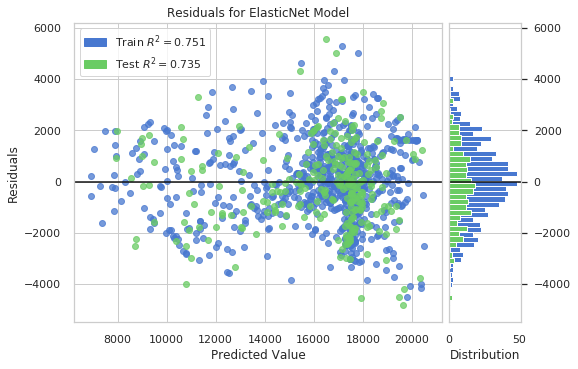

[-1375.85027777   925.09756753  1108.00216999  1233.81903182
  2014.17197199]
1.0


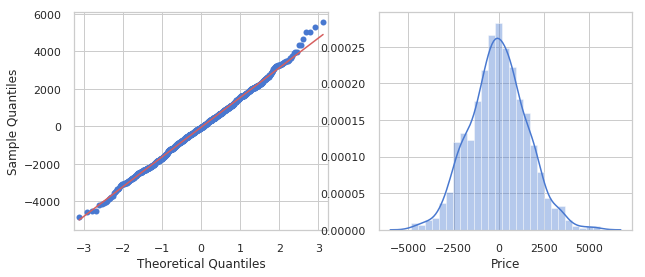

In [66]:
columns = ['Mileage_log', 'Year_ctr', 'XLE', 'XSE', 'Hybrid','Price']
data = toyota[toyota.Mileage > 15000][columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
print(model.coef_)
print(model.l1_ratio)

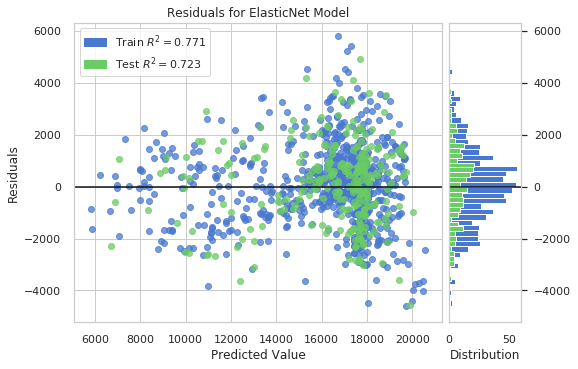

[-1121.12429495  1875.13996817  1188.3535675   1764.19224926
  2326.77247451]
1.0


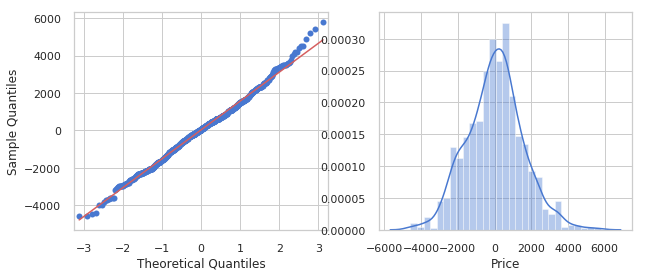

In [67]:
columns = ['Mileage_std', 'Year_std', 'XLE', 'XSE', 'Hybrid','Price']
data = toyota[toyota.Mileage > 15000][columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
print(model.coef_)
print(model.l1_ratio)

# Ananlyzing Honda cars

In [68]:
honda = car_listings[(car_listings.Make == 'Honda')].copy()
honda.sort_values(by='Mileage', inplace=True)
honda.reset_index(inplace=True,drop=True)
honda.describe()

,Year,Price,Mileage
count,1058.000000,1058.000000,1058.000000
mean,2015.645558,17660.135161,42601.015123
std,2.923510,5576.606404,39149.931991
min,2002.000000,1855.000000,604.000000
25%,2015.000000,14972.250000,16419.250000
50%,2017.000000,17792.000000,31845.500000
75%,2018.000000,20988.250000,54455.000000
max,2019.000000,32080.000000,279638.000000


In [69]:
honda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 7 columns):
Year              1058 non-null int64
Make              1058 non-null object
Model             1058 non-null object
Detailed_model    1056 non-null object
Price             1058 non-null float64
Mileage           1058 non-null float64
Website           1058 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 57.9+ KB


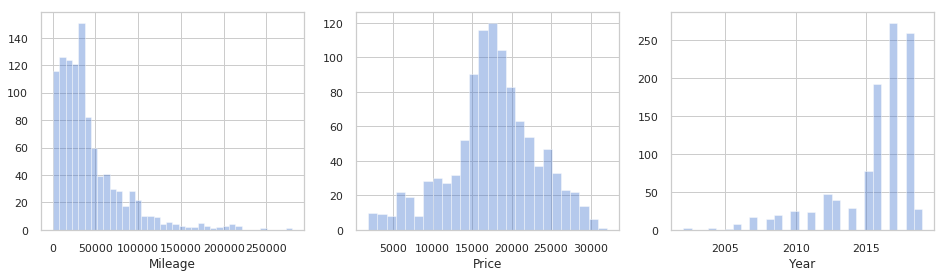

In [70]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(honda.Mileage, kde=False, ax=axes[0])
sns.distplot(honda.Price, kde=False, ax=axes[1])
sns.distplot(honda.Year, kde=False, ax=axes[2])

In [71]:
display(honda.head())
display(honda.tail())
display([honda.Mileage.mean() - 3 * honda.Mileage.std(), honda.Mileage.mean() + 3 * honda.Mileage.std()])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
0,2018,Honda,Accord,EX-L,30100.0,604.0,ED
1,2018,Honda,Accord,LX,22100.0,825.0,ED
2,2019,Honda,Accord,Sport 2.0T,27888.0,898.0,TC
3,2019,Honda,Accord,LX 1.5T,21984.0,1113.0,TC
4,2019,Honda,Accord,EX,24396.0,1119.0,ED


,Year,Make,Model,Detailed_model,Price,Mileage,Website
1053,2007,Honda,Accord,LX,2388.0,214844.0,ED
1054,2007,Honda,Accord,LX Sedan I4,2488.0,214844.0,TC
1055,2009,Honda,Accord,LX Sedan I4,3988.0,215049.0,TC
1056,2004,Honda,Accord,EX,1855.0,248143.0,ED
1057,2005,Honda,Accord,EX V-6,1995.0,279638.0,ED


[-74848.78084913114, 160050.81109487783]

In [72]:
outliers = honda[honda.Mileage > honda.Mileage.mean() + 3*honda.Mileage.std()]
outliers.shape

(26, 7)

In [0]:
honda.drop(outliers.index, inplace=True)

In [74]:
display(honda.sort_values(by="Year").head())
display(honda.sort_values(by="Year").tail())
display([honda.Year.mean() - 3 * honda.Year.std(), honda.Year.mean() + 3 * honda.Year.std()])

,Year,Make,Model,Detailed_model,Price,Mileage,Website
1022,2002,Honda,Accord,VP with Side Airbags Sedan,2688.0,138375.0,TC
1031,2006,Honda,Accord,EX-L Sedan,4995.0,158697.0,TC
945,2006,Honda,Accord,EX-L Sedan,7495.0,91948.0,TC
1025,2006,Honda,Accord,EX-L V6 with Navigation Sedan,6499.0,141303.0,TC
976,2006,Honda,Accord,EX-L Sedan,6991.0,100835.0,TC


,Year,Make,Model,Detailed_model,Price,Mileage,Website
32,2019,Honda,Accord,EX-L,26399.0,3540.0,ED
35,2019,Honda,Accord,Touring,30194.0,3627.0,ED
40,2019,Honda,Accord,EX-L,26385.0,3911.0,ED
15,2019,Honda,Accord,EX-L,28440.0,2067.0,ED
96,2019,Honda,Accord,Sport,22768.0,6927.0,ED


[2008.0193203096405, 2023.6957959694291]

In [75]:
outliers_year = honda[honda.Year < honda.Year.mean() - 3*honda.Year.std()]
outliers_year.shape

(26, 7)

In [0]:
honda.drop(outliers_year.index, inplace=True)

In [77]:
honda.describe()

,Year,Price,Mileage
count,1006.000000,1006.000000,1006.000000
mean,2016.084493,18306.577535,36710.805169
std,2.217034,4899.383752,28109.336051
min,2009.000000,5490.000000,604.000000
25%,2015.000000,15487.250000,15759.250000
50%,2017.000000,17995.000000,30396.000000
75%,2018.000000,21167.500000,48762.000000
max,2019.000000,32080.000000,153341.000000


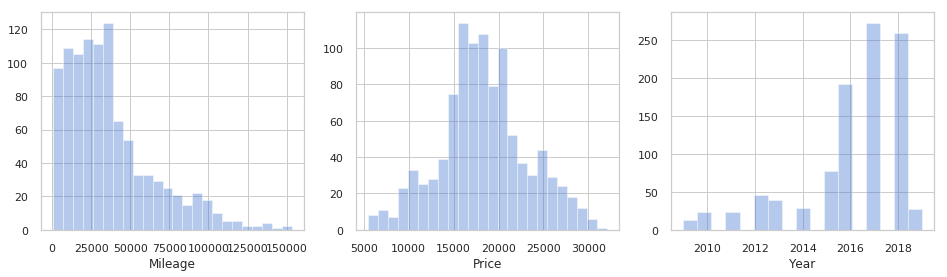

In [78]:
fig = plt.figure(figsize=(16, 4))
axes = fig.subplots(1,3)
sns.distplot(honda.Mileage, kde=False, ax=axes[0])
sns.distplot(honda.Price, kde=False, ax=axes[1])
sns.distplot(honda.Year, kde=False, ax=axes[2])

---

In [0]:
honda['Year_ctr'] = transform(honda.Year, 'center')
honda['Year_std'] = transform(honda.Year, 'standardize')
honda['Mileage_ctr'] = transform(honda.Mileage, 'center')
honda['Mileage_SQRT_std'] = transform(transform(honda.Mileage, np.sqrt), 'standardize')
honda['Year_SQ_std'] = transform(honda.Year **2, 'standardize')
honda['Mileage_std'] = transform(honda.Mileage, 'standardize')
honda['LX'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('LX', na=False)]
honda['ALL_EX'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('EX', na=False)]
honda['EXL'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('EX-L', na=False)]
honda['EX'] = [1 if (ex == 1) & (exl == 0) else 0 for ex, exl in zip(honda.ALL_EX.to_list(), honda.EXL.to_list())]
honda['Sport'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('Sport', na=False)]
honda['Touring'] = [1 if entry else 0 for entry in honda.Detailed_model.str.contains('Touring', na=False)]

---

In [0]:
honda.Detailed_model.str.

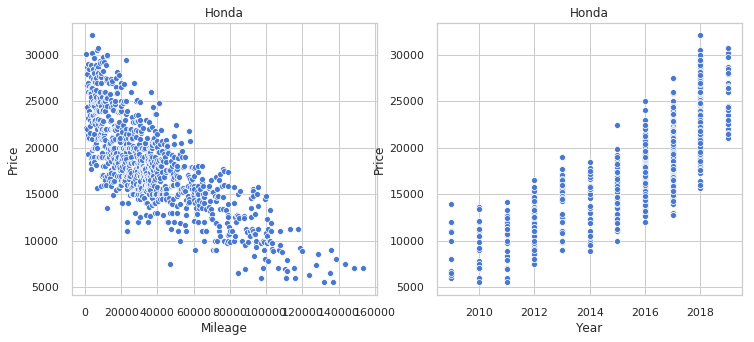

In [80]:
plot('Honda', honda)

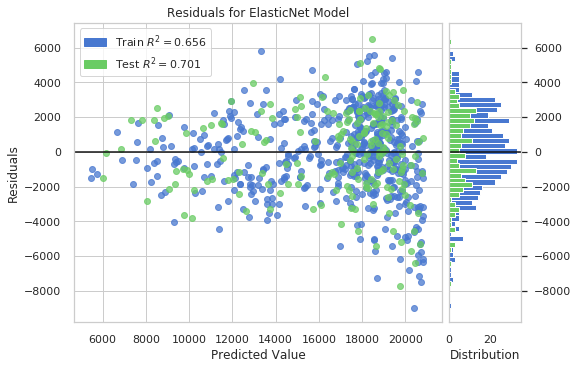

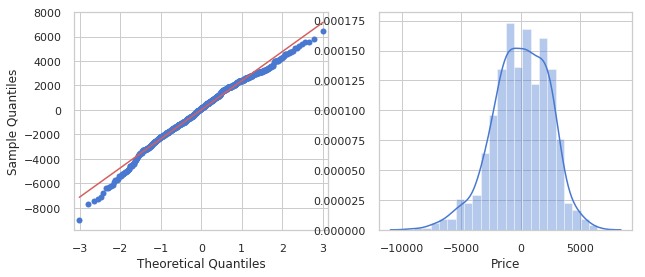

In [81]:
columns = ['Mileage_std', 'Year_std','Price']
data = honda[honda.Mileage > 15000][columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(10,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])

In [82]:
honda.groupby(by='Detailed_model').agg({'Price':['count', 'mean', 'std'], 'Mileage': 'mean', 'Year': 'mean'})

Price  ...         Year
                                            count  ...         mean
Detailed_model                                     ...             
1.5T LX FWD                                     1  ...  2018.000000
1.5T Sport FWD                                  2  ...  2018.000000
2.0T Sport FWD                                  1  ...  2018.000000
2.0T Touring FWD                                2  ...  2018.000000
EX                                             55  ...  2015.563636
EX 1.5T                                         6  ...  2018.166667
EX Coupe                                        2  ...  2017.000000
EX Coupe I4                                     6  ...  2011.666667
EX Sedan                                        8  ...  2017.000000
EX Sedan I4                                    22  ...  2014.318182
EX w/Honda Sensing                              4  ...  2016.500000
EX with Honda Sensing Coupe                     1  ...  2017.000000
EX with Honda Sensing Coupe I4                  1  ...  2016.000000
EX with Honda Sensing Sedan                     2  ...  2017.000000
EX with Honda Sensing Sedan I4                  1  ...  2016.000000
EX-L                                           89  ...  2016.561798
EX-L 1.5T                                       9  ...  2018.000000
EX-L 2.0T                                       3  ...  2018.000000
EX-L Coupe                                      4  ...  2017.000000
EX-L Coupe I4                                   7  ...  2014.142857
EX-L FWD                                        1  ...  2017.000000
EX-L FWD Used                                   1  ...  2017.000000
EX-L Sedan                                     14  ...  2017.000000
EX-L Sedan I4                                  20  ...  2013.900000
EX-L V-6                                       36  ...  2013.861111
EX-L V-6 w/Navigation                           1  ...  2013.000000
EX-L V-6 w/Navigation and Honda Sensing         5  ...  2016.600000
EX-L V6 Coupe                                   9  ...  2014.222222
EX-L V6 Sedan                                  22  ...  2013.500000
EX-L V6 with Honda Sensing/Navigation Sedan     2  ...  2016.500000
...                                           ...  ...          ...
LX Sedan I4                                    48  ...  2015.104167
LX w/Honda Sensing                              4  ...  2016.250000
LX with Honda Sensing Sedan I4                  2  ...  2016.000000
LX-P                                            7  ...  2010.285714
LX-P Sedan I4                                   5  ...  2011.600000
LX-S                                            6  ...  2013.333333
LX-S Coupe                                      3  ...  2017.000000
LX-S Coupe I4                                   3  ...  2014.666667
LX-S w/Honda Sensing                            1  ...  2016.000000
SE                                              8  ...  2011.500000
SE Sedan I4                                     8  ...  2011.750000
Sport                                         127  ...  2016.897638
Sport 1.5T                                     21  ...  2018.095238
Sport 2.0T                                      3  ...  2018.333333
Sport SE FWD                                    1  ...  2017.000000
Sport Sedan                                    24  ...  2017.000000
Sport Sedan I4                                 38  ...  2015.631579
Sport Special Edition                          13  ...  2017.000000
Sport Special Edition Sedan                    26  ...  2017.000000
Sport w/Honda Sensing                           2  ...  2016.500000
Sport with Honda Sensing Sedan                  2  ...  2017.000000
Sport with Honda Sensing Sedan I4               4  ...  2016.000000
Touring                                        26  ...  2018.076923
Touring 1.5T                                   11  ...  2018.000000
Touring 2.0T                                    8  ...  2018.125000
Touring Coupe                   

In [107]:
honda.Detailed_model.unique().shape

(78,)

In [83]:
display(honda[honda.Detailed_model.str.contains('Sport',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('LX',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('Touring',na=False)].shape)
display(honda[honda.Detailed_model.str.contains('EX',na=False)].shape)

(264, 17)

(290, 17)

(66, 17)

(367, 17)

In [84]:
display(honda[honda.Detailed_model.str.contains('LX',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('EX',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('Sport',na=False)].Price.mean())
display(honda[honda.Detailed_model.str.contains('Touring',na=False)].Price.mean())

16053.124137931034

18422.623978201635

19148.81818181818

25891.030303030304

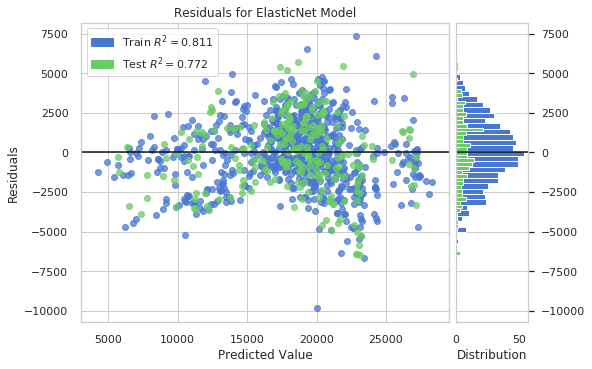

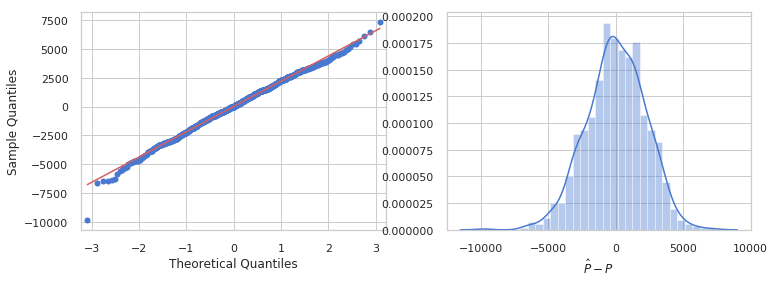

In [149]:
columns = ['Mileage_std', 'Year_std', 'ALL_EX', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

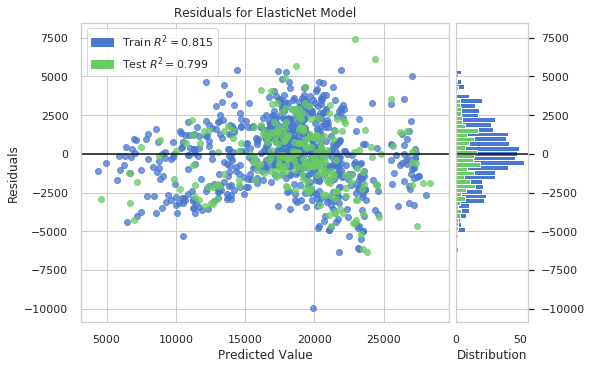

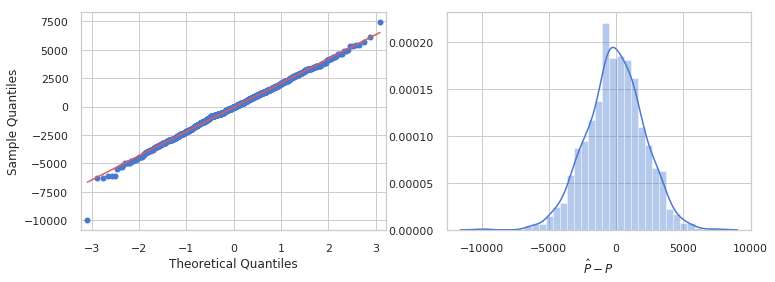

In [147]:
columns = ['Mileage_std', 'Year_std', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

In [101]:
hybrid = honda[honda.Detailed_model.str.contains('Hybrid', na=False)]
display(hybrid.shape)
display(honda.shape)
display(honda.drop(hybrid.index).shape)

(12, 17)

(1006, 17)

(994, 17)

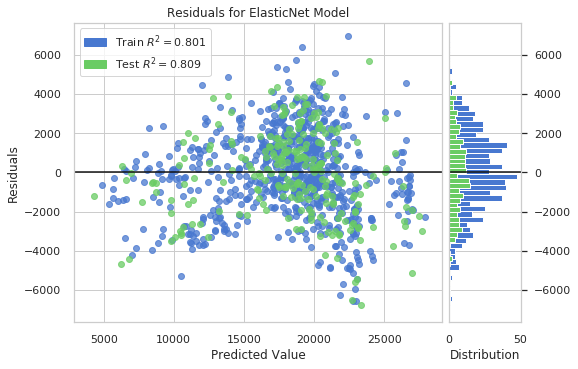

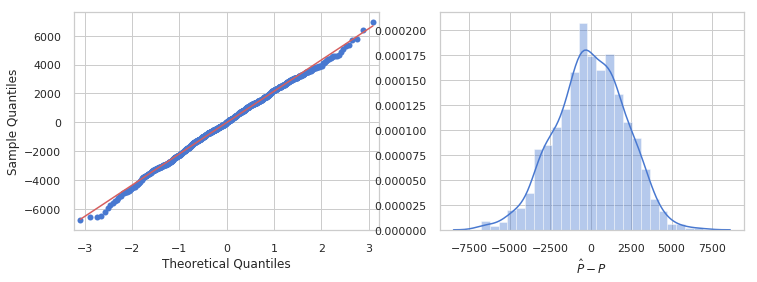

In [100]:
columns = ['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price']
data = honda[columns].drop(hybrid.index)
model = train_test_plot(data,columns, regularizer='e')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

In [86]:
result = performance(honda,['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16413.421151309718, 16657.98649131989],
               'mean': 16535.703821314804},
 'R2_on_testset': {'CI': [0.7653959238299456, 0.832658733365265],
                   'mean': 0.7990273285976053},
 'RMSE': {'CI': [2182.7843115131373, 2188.4021404053256],
          'mean': 2185.5932259592314},
 'coef_CI': [(-2075.9016998847906, -1837.178346747136),
             (1956.2558245341704, 2192.3210224094637),
             (2424.3817692148446, 2794.5580897218565),
             (1257.3646353690704, 1684.399109938937),
             (6277.44732555714, 6951.959761843443)],
 'coef_means': array([-1956.54002332,  2074.28842347,  2609.46992947,  1470.88187265,
        6614.7035437 ])}


In [87]:
print(toyota.Mileage.std())
print(honda.Mileage.std())

24514.625215627075
28109.336051205748


In [102]:
result = performance(honda.drop(hybrid.index),['Mileage_std', 'Year_std', 'EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='e')
pprint(result)

{'Intercept': {'CI': [16389.49080403144, 16643.50918463796],
               'mean': 16516.4999943347},
 'R2_on_testset': {'CI': [0.7616792137182801, 0.8387060087922994],
                   'mean': 0.8001926112552897},
 'RMSE': {'CI': [2162.432957268665, 2167.7451298631863],
          'mean': 2165.0890435659257},
 'coef_CI': [(-2034.5897378861855, -1847.1843586222176),
             (1959.0190323706322, 2181.8858561939687),
             (2377.2158734271784, 2806.37810887311),
             (1274.5978151991733, 1691.359728820599),
             (6252.180534592053, 6902.470626429385)],
 'coef_means': array([-1940.88704825,  2070.45244428,  2591.79699115,  1482.97877201,
        6577.32558051])}


In [153]:
result = performance(honda.drop(hybrid.index),['Mileage_std', 'Year_std', 'EX','EXL', 'Sport', 'Touring', 'Price'], rep=100, regularizer='r')
pprint(result)

{'Intercept': {'CI': [16336.880979728121, 16621.844293655646],
               'mean': 16479.362636691883},
 'R2_on_testset': {'CI': [0.7718898452128509, 0.8483354976226489],
                   'mean': 0.8101126714177499},
 'RMSE': {'CI': [2098.504652559484, 2103.5902380349794],
          'mean': 2101.0474452972317},
 'coef_CI': [(-2063.928593236786, -1853.2467256959253),
             (1930.5081417417769, 2166.1595480421656),
             (1037.202522004371, 1521.771011558058),
             (2982.1173341592807, 3394.7150043913875),
             (1342.5217632339718, 1734.9358652773963),
             (6218.034065458761, 7056.925026557071)],
 'coef_means': array([-1958.58765947,  2048.33384489,  1279.48676678,  3188.41616928,
        1538.72881426,  6637.47954601])}


In [88]:
result = performance(honda,['Mileage_SQRT_std', 'Year_SQ_std', 'EX', 'Sport', 'Touring', 'Price'], rep=100, regularizer='r')
pprint(result)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'Intercept': {'CI': [16447.256511284588, 16715.745385116727],
               'mean': 16581.500948200657},
 'R2_on_testset': {'CI': [0.7831011730938998, 0.8418654081983227],
                   'mean': 0.8124832906461112},
 'RMSE': {'CI': [2106.253378801565, 2110.4124378874553],
          'mean': 2108.33290834451},
 'coef_CI': [(-2201.576452696658, -1975.8661127257344),
             (1909.4724520181942, 2128.397906896814),
             (2342.961582388556, 2674.860186014217),
             (1281.7021156218286, 1692.1396695821347),
             (6038.16038658655, 6722.778172192519)],
 'coef_means': array([-2088.72128271,  2018.93517946,  2508.9108842 ,  1486.9208926 ,
        6380.46927939])}


In [152]:
print(honda[honda.EXL == 1].Price.mean())
honda[honda.EX == 1].Price.mean()

19061.386100386102


16890.777777777777

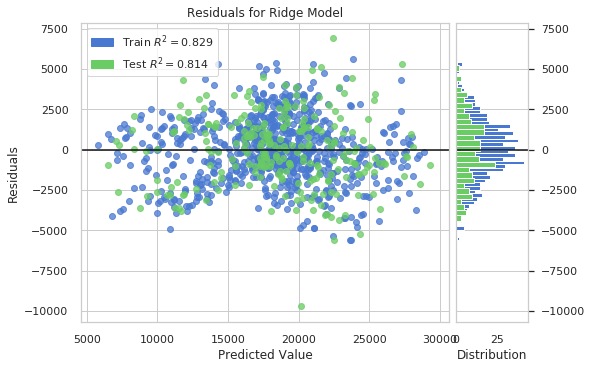

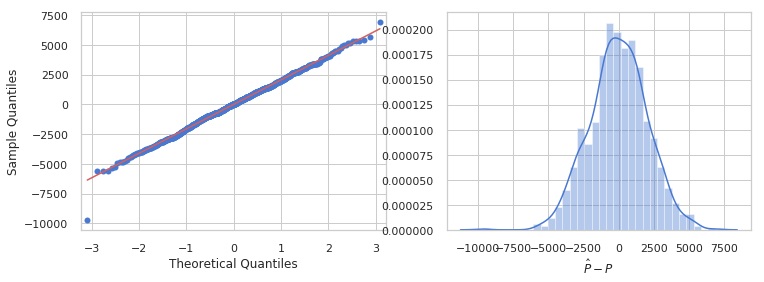

In [154]:
columns = ['Mileage_SQRT_std', 'Year_std', 'EX', 'EXL', 'Sport', 'Touring', 'Price']
data = honda[columns]
model = train_test_plot(data,columns, regularizer='r')
residuals = model.predict(data.drop('Price', axis=1))  -  data.Price
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(1,2)
qqplot(residuals, line='r',ax=axes[0]);
sns.distplot(residuals, ax=axes[1])
axes[1].set_xlabel('$\hat{P} - P$');

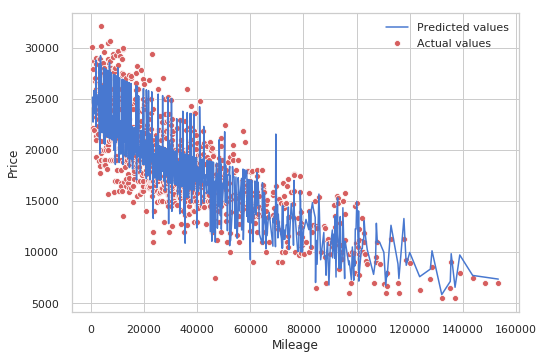

In [90]:
fig, ax = plt.subplots()
interval = 1.96 * np.sqrt(np.sum(residuals**2)/(residuals.shape[0] - 1))
predictions = model.predict(honda[['Mileage_SQRT_std', 'Year_std', 'EX', 'Sport', 'Touring']])
upper, lower = predictions + interval, predictions - interval
sns.scatterplot(x=honda.Mileage, y=honda.Price, ax=ax,color='r', label="Actual values")
sns.lineplot(x=honda.Mileage, y=predictions, ax=ax, label="Predicted values")
#sns.scatterplot(x=honda.Mileage, y=lower, ax=ax)

I am in <span style="font-family:Times Roman; font-size:4em;">LOVE!</span>

This is some <sup>superscript</sup> text